# XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from utils import reduce_memory_usage, get_dataset_dtypes, derivate_features, get_model_metrics, get_roc_curves
from sklearn import model_selection
from itertools import cycle

import xgboost as xgb
%matplotlib inline 

In [2]:
dtypes, numerical_columns, categorical_columns = get_dataset_dtypes()

In [3]:
path = './datasets/train_preprocessed.csv'

In [4]:
df_train = pd.read_csv(path, dtype=dtypes, index_col=[0])

In [5]:
df_train = df_train.sample(frac = 0.5)

In [6]:
print(f"Train dataset shape: {df_train.shape}")

Train dataset shape: (3833896, 67)


In [7]:
X_columns = ['AVProductsInstalled',
             'SmartScreen',
             'AVProductStatesIdentifier',
             'Census_OSArchitecture',
             'AppVersion_2',
             'Census_TotalPhysicalRAM',
             'IsProtected',
             'EngineVersion',
             'Census_SystemVolumeTotalCapacity',
             'AppVersion_3',
             'Census_FirmwareVersionIdentifier',
             'Census_ProcessorModelIdentifier',
             'Census_OEMModelIdentifier',
             'CountryIdentifier',
             'OrganizationIdentifier'
             ]


**Important!**

XGBoost does not support categorical cols by default...so, we must apply a label encoding

In [8]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()

df_train['SmartScreen'] = lbl.fit_transform(df_train['SmartScreen'].astype(str))
df_train['Census_OSArchitecture'] = lbl.fit_transform(df_train['Census_OSArchitecture'].astype(str))
df_train['EngineVersion'] = lbl.fit_transform(df_train['EngineVersion'].astype(str))

In [9]:
X = df_train[X_columns]
y = df_train["HasDetections"]
del df_train

In [10]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=31)

In [11]:
xgb_params = {
    'learning_rate': 0.1,
    'n_estimators': 100, 
    'max_depth': 10,
    'min_child_weight': 2,
    'gamma': 0.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'nthread': -1,
    'scale_pos_weight': 1,
    'reg_alpha':  0,
    'reg_lambda':  1,
    'seed': 42
}

In [12]:
clf = xgb.XGBClassifier(**xgb_params)

In [13]:
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, ...)

## Metricas

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import label_binarize

In [15]:
y_pred= clf.predict(x_test)

In [16]:
conf_matrix = get_model_metrics(y_test, y_pred, 'XGBoost')


---Metrics for XGBoost---

 Confusion Matrix
 [[242883 138745]
 [128874 256278]]

 Accuracy 0.650983332898615

 Precision 0.6510421739947614

 Recall 0.650983332898615

 F1 Score 0.6509048199951679


## Curva ROC

In [17]:
 y_score = clf.predict_proba(x_test)

In [18]:
y_test.shape

(766780,)

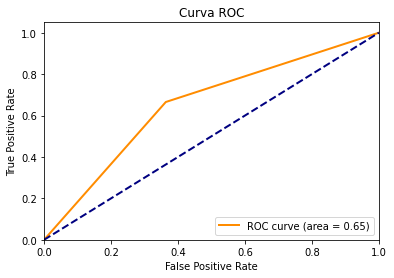

In [19]:
get_roc_curves(y_test,y_pred)

## K - folds

In [20]:
from xgboost import cv

data_dmatrix = xgb.DMatrix(data=X,label=y)
xgb_cv = cv(
    dtrain=data_dmatrix,
    params=xgb_params,
    nfold=3,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics="auc",
    as_pandas=True,
    seed=123
)

# Old way to calc cross validation...
# k_fold_val(clf, X, y, "Naive Bayes", splits = 10)

[01:24:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:24:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:24:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64

xgb_cv contains train and test auc metrics for each boosting round...

In [21]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.691633,0.000194,0.688877,0.000331
1,0.692724,0.000247,0.689879,0.000309
2,0.693383,0.000155,0.690455,0.000394
3,0.693915,0.000129,0.690921,0.000439
4,0.694667,0.000196,0.691611,0.000359


## Haciendo Predicciones

In [ ]:
# TBD